In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd()
figurepath = Path.cwd()

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [7]:
def model(x,a,b):
    return a*x**b

In [8]:
jobids = []
params = []
data_a3 = []
data_a6 = []
data_nn = []
data = []

top_folders = [datapath/"alpha = 3/PBC",datapath/"alpha = 6/PBC",datapath/"nn/PBC"]
h_folders = ["h = 0","h = 3","h = 6","h = 9","h = 12","h = 15","h = 18","h = 21","h = 24"]
folders = [top_folders[i]/h_folders[j] for i in range(len(top_folders)) for j in range(len(h_folders))]
files = ["combined_file_h{}.jld2".format(h) for i in range(len(top_folders)) for h in [0,3,6,9,12,15,18,21,24]]

for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])


for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])

data_a3 = data[0:len(h_folders)]
data_a6 = data[len(h_folders):2*len(h_folders)]
data_nn = data[2*len(h_folders):3*len(h_folders)]

In [9]:
N = 13
hs = [0,3,6,9,12,15,18,21,24]
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [10]:
res_a3 = [disorder_mean(data_a3[i]) for i in range(len(data_a3))]
res_sem_a3 = [disorder_sem(data_a3[i]) for i in range(len(data_a3))]
red_a3 = list(map(symmetrize,res_a3))
red_sem_a3 = list(map(symmetrize,res_sem_a3))

res_a6 = [disorder_mean(data_a6[i]) for i in range(len(data_a6))]
res_sem_a6 = [disorder_sem(data_a6[i]) for i in range(len(data_a6))]
red_a6 = list(map(symmetrize,res_a6))
red_sem_a6 = list(map(symmetrize,res_sem_a6))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(data_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(data_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

In [11]:
for i in range(len(data_a3)):
    print("h = ",hs[i]," a3: ",data_a3[i].shape[2]," a6: ",data_a6[i].shape[2]," nn: ",data_nn[i].shape[2],"\n")

h =  0  a3:  25  a6:  25  nn:  25 

h =  3  a3:  100  a6:  100  nn:  100 

h =  6  a3:  100  a6:  100  nn:  100 

h =  9  a3:  100  a6:  100  nn:  100 

h =  12  a3:  100  a6:  100  nn:  100 

h =  15  a3:  100  a6:  100  nn:  100 

h =  18  a3:  100  a6:  100  nn:  100 

h =  21  a3:  100  a6:  100  nn:  100 

h =  24  a3:  100  a6:  100  nn:  100 



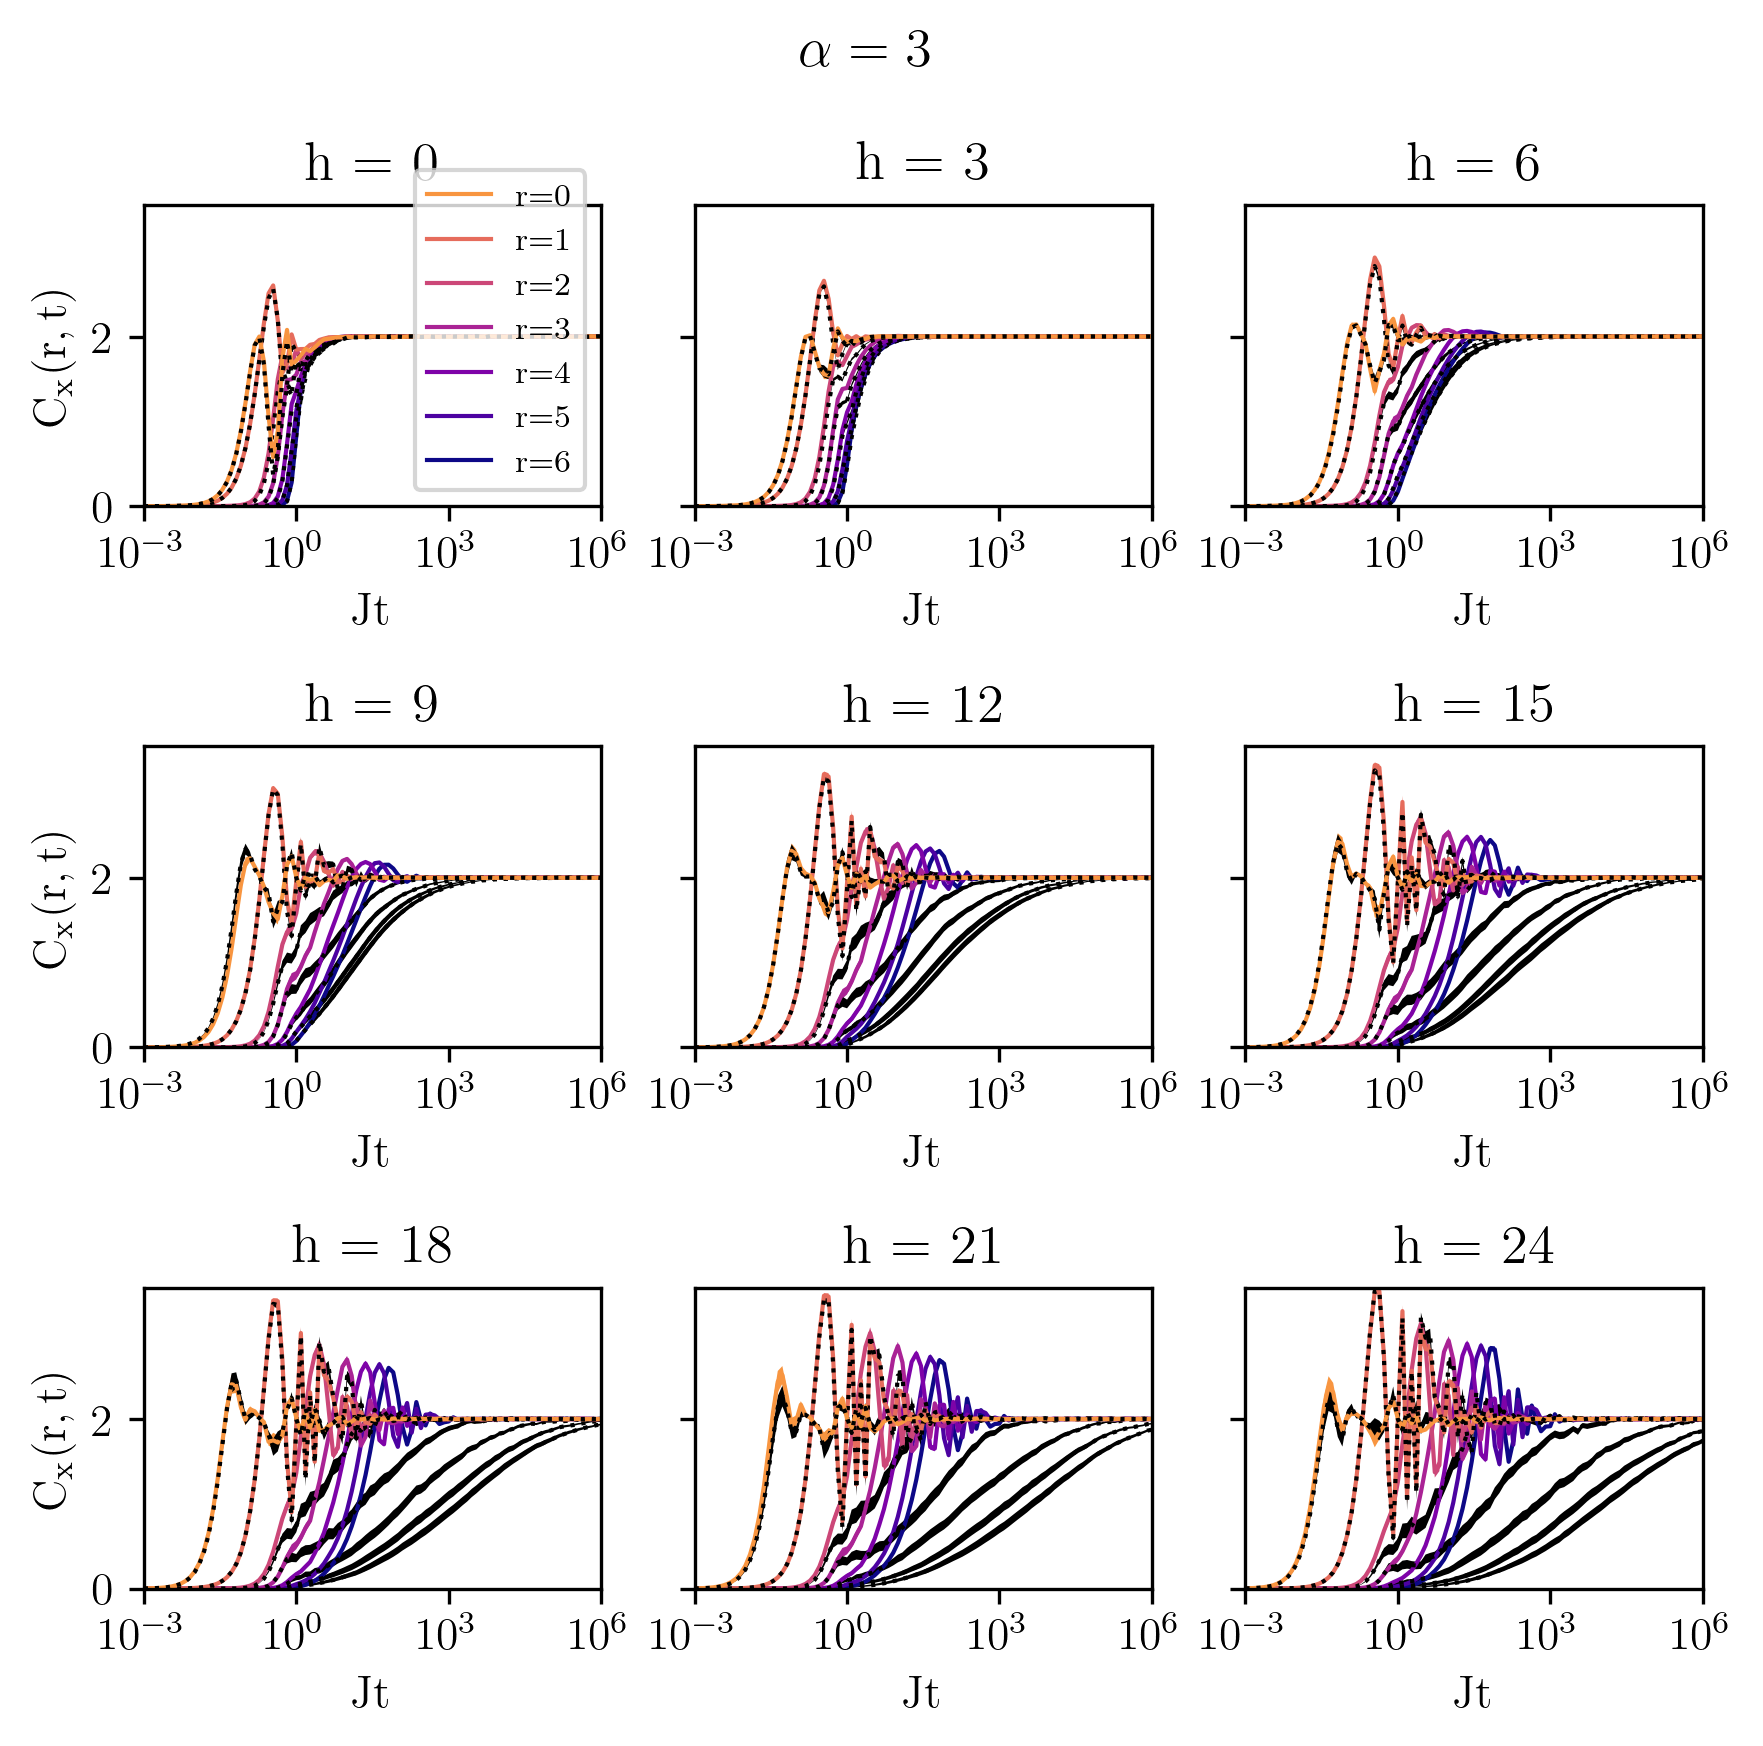

In [12]:
fig, axs = plt.subplots(3,3,figsize=set_size(subplots=(3,3)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


k = 0
for pi in range(0,3):
    for pj in range(0,3):
        axs[pi,pj].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
        axs[pi,pj].set_xscale("log")
        for j in range(0,N//2+1):
            axs[pi,pj].plot(T,red_a3[pi+pj+k][:,j],label="r={}".format(rvals[j]),lw=1)
            axs[pi,pj].plot(T,red_nn[pi+pj+k][:,j],ls="dotted",c="black",lw=1)

            axs[pi,pj].fill_between(T, red_a3[pi+pj+k][:,j]-red_sem_a3[pi+pj+k][:,j], red_a3[pi+pj+k][:,j]+red_sem_a3[pi+pj+k][:,j])
            axs[pi,pj].fill_between(T, red_nn[pi+pj+k][:,j]-red_sem_nn[pi+pj+k][:,j], red_nn[pi+pj+k][:,j]+red_sem_nn[pi+pj+k][:,j],fc="black")

        axs[pi,pj].set_xlabel(r"Jt")
        axs[pi,pj].set_title("h = {}".format(hs[pi+pj+k]))
        axs[pi,pj].set_xlim(1e-3,1e6)
        if pj == 0:
            axs[pi,pj].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    k += 2


handles, labels = axs[0,0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")
axs[0,0].set_xlabel(r"Jt")
axs[0,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0,0].set_title("h = {}".format(hs[0]))
axs[0,0].set_xlim(1e-3,1e6)
axs[0,0].set_ylim(0,3.55)



plt.suptitle(r"$\alpha=3$")
plt.tight_layout()
#plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.savefig(figurepath/"gallery_a3.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

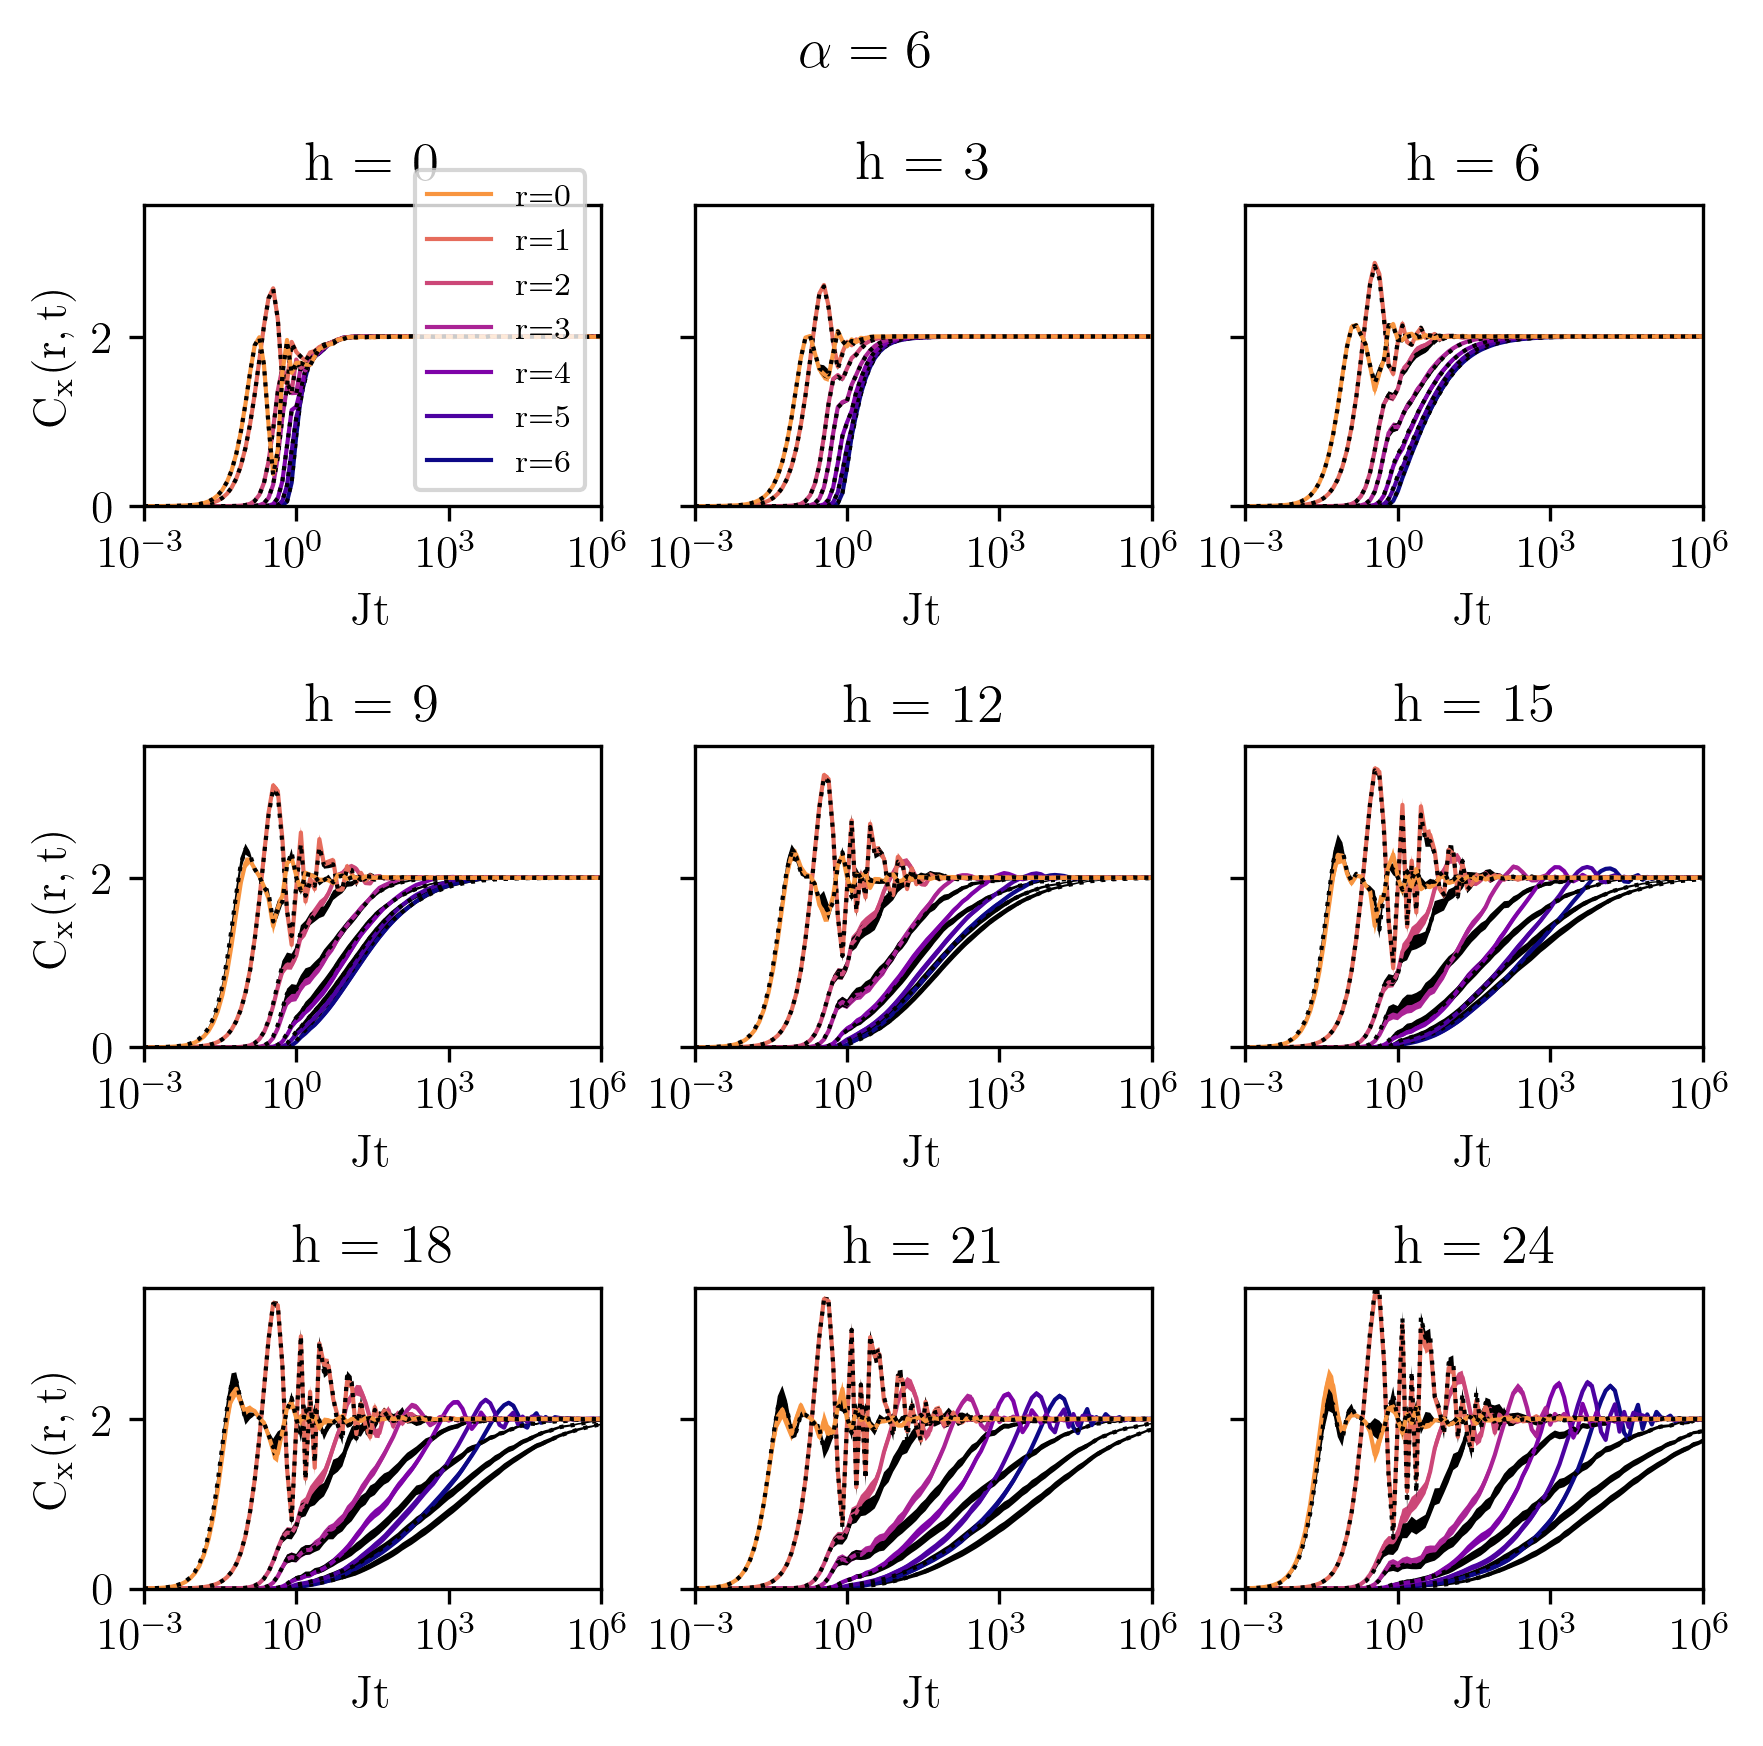

In [13]:
fig, axs = plt.subplots(3,3,figsize=set_size(subplots=(3,3)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


k = 0
for pi in range(0,3):
    for pj in range(0,3):
        axs[pi,pj].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
        axs[pi,pj].set_xscale("log")
        for j in range(0,N//2+1):
            axs[pi,pj].plot(T,red_a6[pi+pj+k][:,j],label="r={}".format(rvals[j]),lw=1)
            axs[pi,pj].plot(T,red_nn[pi+pj+k][:,j],ls="dotted",c="black",lw=1)

            axs[pi,pj].fill_between(T, red_a6[pi+pj+k][:,j]-red_sem_a6[pi+pj+k][:,j], red_a6[pi+pj+k][:,j]+red_sem_a6[pi+pj+k][:,j])
            axs[pi,pj].fill_between(T, red_nn[pi+pj+k][:,j]-red_sem_nn[pi+pj+k][:,j], red_nn[pi+pj+k][:,j]+red_sem_nn[pi+pj+k][:,j],fc="black")

        axs[pi,pj].set_xlabel(r"Jt")
        axs[pi,pj].set_title("h = {}".format(hs[pi+pj+k]))
        axs[pi,pj].set_xlim(1e-3,1e6)
        if pj == 0:
            axs[pi,pj].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    k += 2


handles, labels = axs[0,0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")
axs[0,0].set_xlabel(r"Jt")
axs[0,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0,0].set_title("h = {}".format(hs[0]))
axs[0,0].set_xlim(1e-3,1e6)
axs[0,0].set_ylim(0,3.55)

plt.suptitle(r"$\alpha=6$")
plt.tight_layout()
#plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.savefig(figurepath/"gallery_a6.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

18


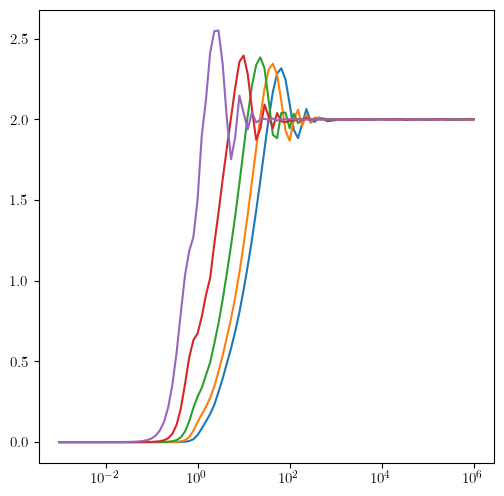

In [33]:
plt.semilogx(T,red_a3[-5][:,:-2])
print(hs[-3])

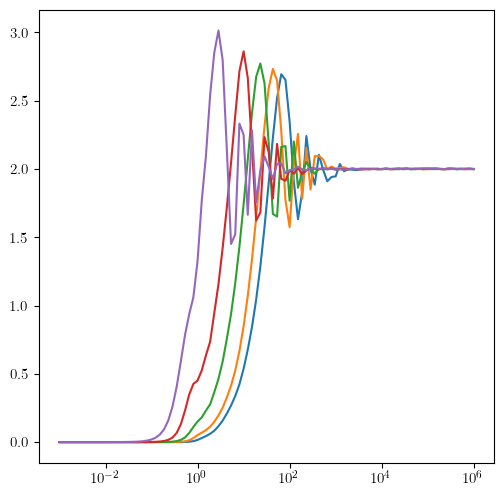

In [34]:
plt.semilogx(T,red_a3[-2][:,:-2])


12


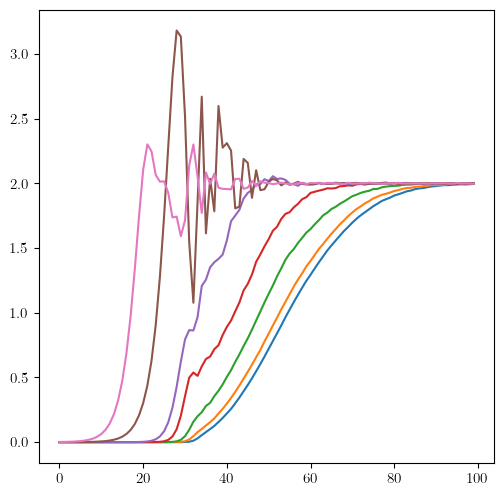

In [35]:
plt.plot(red_nn[-5])
print(hs[-5])

In [38]:
red_nn[-4][-1,:]

array([1.98116811, 1.99284991, 1.99989943, 1.99919393, 2.00059227,
       1.99564234, 2.00131088])